In [279]:
import pandas as pd
import numpy as np

In [280]:
# read the csv file
df = pd.read_csv('https://github.com/Alnasser0/COMP5310-Project/raw/main/cleaned_data.csv')

In [281]:
df = df.dropna()
df = df[df.Avail_Airbag == "Yes"]

In [282]:
df = df[df.Injury_Severity.isin([0, 1, 2, 3, 4])]
severity_levels = ['None', 'Possible', 'Possible', 'Severe', 'Severe']
df['Injury_Severity'] = df.Injury_Severity.apply(lambda x: int(x))
df['Injury_Severity_level'] = df.Injury_Severity.apply(lambda x: severity_levels[x])

In [283]:
df['Acc_Year'] = df.Acc_Year.apply(lambda x: int(x[:4]))
df['Veh_Year'] = df.Veh_Year.apply(lambda x: int(x[:4]))
df['Vehicle_Age'] = df.Acc_Year - df.Veh_Year

In [284]:
from sklearn.preprocessing import OrdinalEncoder
impact_levels = {
    '[1,9]': 1,
    '[10,24]': 2,
    '[25,39]': 3,
    '[40,54]': 4,
    '[55,inf]': 5
}

df['impact_level_numerical'] = df['Impact_Level'].map(impact_levels)

ordinal_encoder = OrdinalEncoder()
df['impact_level_encoded'] = ordinal_encoder.fit_transform(df[['impact_level_numerical']])

In [285]:
df['Age_level'] = pd.qcut(df.Age, 3, labels=['Young', 'Mid', 'Old'])

In [286]:
df = df.drop(columns=['Avail_Airbag', 'Deceased', 'Impact_Level', 'Unnamed: 0', 'Impact_Speed', 'Acc_Year', 'Veh_Year', 'Injury_Severity', 'Weight', 'Age', 'impact_level_encoded'])

In [287]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(df['Injury_Severity_level'])

df['Injury_Severity_level'] = le.transform(df['Injury_Severity_level'])

cols = ['Seat_Belt', 'Front_Impact', 'Sex', 'Role', 'Airbag_Deploy', 'Age_level']
df = pd.get_dummies(df, columns = cols, dtype=float)
df

,Injury_Severity_level,Vehicle_Age,impact_level_numerical,Seat_Belt_No,Seat_Belt_Yes,Front_Impact_No,Front_Impact_Yes,Sex_F,Sex_M,Role_Driver,Role_Passenger,Airbag_Deploy_No,Airbag_Deploy_Yes,Age_level_Young,Age_level_Mid,Age_level_Old
1,1,2,2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,2,3,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,1,6,2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9,2,3,3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
13,0,2,2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22788,1,5,3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
22789,1,0,2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
22790,2,12,2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
22791,0,3,3,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [288]:
df.Injury_Severity_level.value_counts()

Injury_Severity_level
1    5716
2    4770
0    3771
Name: count, dtype: int64

In [289]:
from sklearn.preprocessing import LabelEncoder

#define X and y
X = df.drop(columns=["Injury_Severity_level"])  # Features
y = df["Injury_Severity_level"]  # Outcome variable

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [290]:
# define cvKFold with stratifiedKFold
from sklearn.model_selection import StratifiedKFold
cvKFold= StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

In [291]:
from sklearn.model_selection import train_test_split

def train_test_split_simplified(X, y):
    """Split the data into training and test sets."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state= 0)
    return X_train, y_train, X_test, y_test


In [292]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X_train, y_train, X_test, y_test = train_test_split_simplified(X, y_encoded)

params_to_test = {
    'n_estimators': [10, 30, 50, 100],
    'max_features': ['sqrt', None],
    'min_samples_split': [2, 6, 10, 20],
    'min_samples_leaf': [10, 30, 50, 100],
    'max_depth': [2, 5, 10, 20],
    'max_leaf_nodes': [50, 100, 150]
}

rf_model = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(rf_model, param_grid=params_to_test, cv=cvKFold, scoring='f1_macro', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_ 

best_model = RandomForestClassifier(**best_params)

print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 100, 'min_samples_leaf': 50, 'min_samples_split': 2, 'n_estimators': 100}


In [293]:
from sklearn.metrics import classification_report

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.38      0.44       754
           1       0.46      0.60      0.52      1144
           2       0.57      0.49      0.52       954

    accuracy                           0.50      2852
   macro avg       0.52      0.49      0.49      2852
weighted avg       0.51      0.50      0.50      2852



In [294]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy:", accuracy)
print("Macro average F1 score:", macro_f1)
print("Matthews correlation coefficient:", mcc)

Accuracy: 0.5031556802244039
Macro average F1 score: 0.4945676668600256
Matthews correlation coefficient: 0.23252302789749424


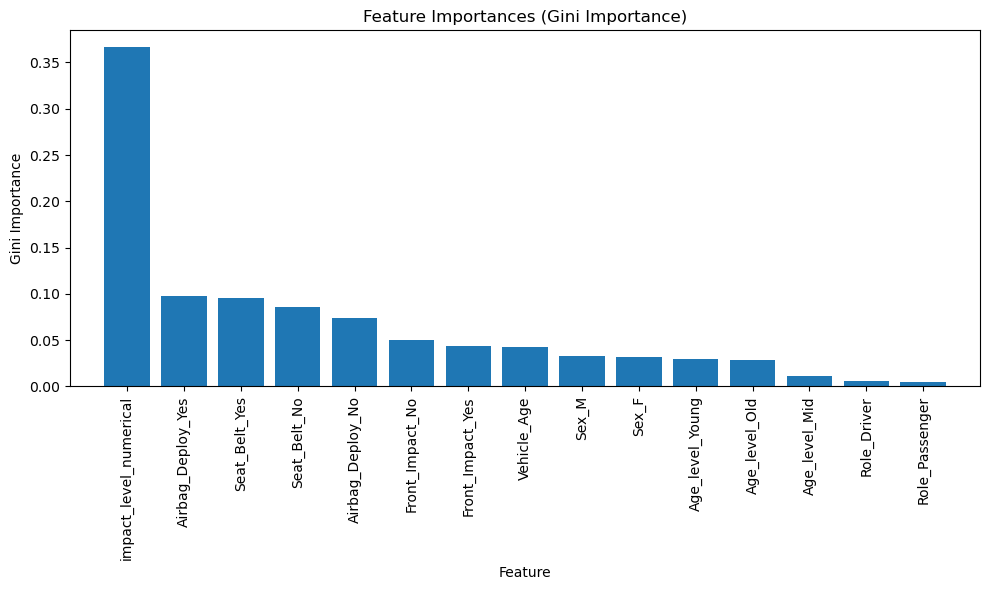

In [295]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_model is already trained
best_model.fit(X_train, y_train)

# Get feature importances
importances = best_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the Gini importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Gini Importance)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("Gini Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


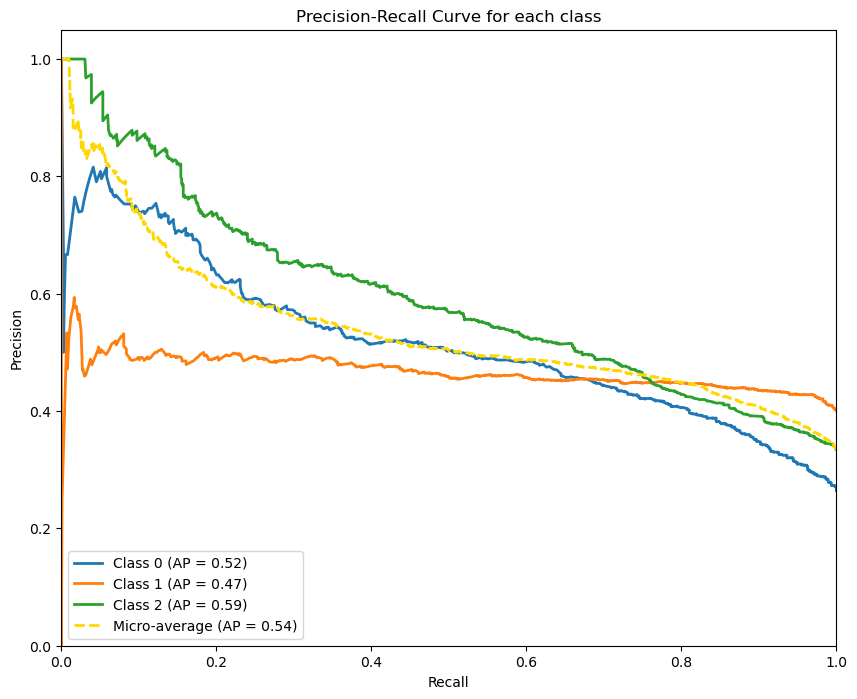

In [296]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Assuming X_train, y_train, X_test, and y_test are defined elsewhere in your code
# Assuming cvKFold is defined for cross-validation

# Train a random forest model using the best parameters obtained from GridSearchCV
rf_model = RandomForestClassifier(**best_params, random_state=0)
rf_model.fit(X_train, y_train)

# Obtain predicted probabilities for each class
y_scores = rf_model.predict_proba(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate Precision-Recall curve and AUC for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(np.unique(y_test))):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])

# Compute micro-average Precision-Recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_scores.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_scores, average="micro")

# Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(recall[i], precision[i], lw=2, label='Class {} (AP = {:0.2f})'.format(i, average_precision[i]))

# Plot micro-average Precision-Recall curve
plt.plot(recall["micro"], precision["micro"], color='gold', linestyle='--', lw=2, label='Micro-average (AP = {:0.2f})'.format(average_precision["micro"]))

# Set plot attributes
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="lower left")
plt.show()
